In [ ]:
pip install Cython

In [ ]:
pip install --upgrade git+https://github.com/statsmodels/statsmodels


In [ ]:
pip install stargazer

In [ ]:
import statsmodels.api as smf
import statsmodels.formula.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import scipy as sp 

In [ ]:
def end_of_month(x):
    if not isinstance(x, str):
        return x
    return str(pd.to_datetime(x) + pd.tseries.offsets.MonthEnd(0))[:10]

In [ ]:
msf = pd.read_parquet('msf.parquet',columns = ['permno', 'date', 'prc', 'shrout', 'hexcd', 'ret'])
msf = msf.loc[msf['date'] > '1964-12-31']
msf = msf[msf['hexcd'].isin(set([1,2,3]))]
msf = msf.assign(end_of_month = lambda df: df['date'].apply(end_of_month))

In [ ]:
four_factor_monthly = pd.read_parquet('four_factor_monthly.parquet')
four_factor_monthly = four_factor_monthly.loc[four_factor_monthly['dt'] > '1964-12-31']
four_factor_monthly = four_factor_monthly.assign(end_of_month = lambda df: df['dt'].apply(end_of_month)) #Sample period starts from 1965

In [ ]:
merge = pd.merge(msf, four_factor_monthly, on = 'end_of_month')
merge = merge.sort_values(['permno', 'date']).reset_index(drop=True)
merge['ret_rf'] = merge['ret'] - merge['rf']
merge['market_cap'] = abs(merge['prc'] * merge['shrout'])

In [ ]:
len(merge)

4023201

Rolling Regression for each permno


In [ ]:
container = pd.read_parquet('coeff.parquet')
merge[['constant', 'beta']] = container 
merge['residual'] = merge['ret_rf'] - merge['constant'] - merge['beta']*merge['mkt_rf']

In [ ]:
#empty dataframe to hold the coefficients
#It is essentially a grouped rolling regression with window = 36 months 
container = pd.DataFrame(columns = ['const', 'mkt_rf'])
for i in range (10000, int(merge['permno'].max())+1):
  temp = merge.loc[merge['permno'] == i]
  if temp.shape[0] <36:
    pass
  else:
    fit = RollingOLS(temp['ret_rf'], smf.add_constant(temp['mkt_rf']), window = 36).fit()
    params = fit.params
    container = container.append(params)
  
merge[['constant', 'beta']] = container 
merge['residual'] = merge['ret_rf'] - merge['constant'] - merge['beta']*merge['mkt_rf']


Create Lag variables

In [ ]:
merge['market_cap_lag1'] = merge.groupby(['permno'])['market_cap'].shift(1)
merge['ret_lag1'] = merge.groupby(['permno'])['ret'].shift(1)
merge['prc_lag1'] = merge.groupby(['permno'])['prc'].shift(1).abs()
merge['prc_lag13'] = merge.groupby(['permno'])['prc'].shift(13).abs()

Calculate Rolling Return

In [ ]:
# Rolling Residual
def rolling_prod(a, n=11) :
    ret = np.cumprod(a.values)
    ret[n:] = ret[n:] / ret[:-n]
    ret[:n-1] = np.nan
    return pd.Series(ret, index=a.index)

merge['rolling_residual_11_months'] = (
    merge
    .assign(ret=(merge['residual'].fillna(0)+1))
    .groupby('permno')['ret']
    .apply(rolling_prod)
) - 1

#Rolling Return
def rolling_prod(a, n=11) :
    ret = np.cumprod(a.values)
    ret[n:] = ret[n:] / ret[:-n]
    ret[:n-1] = np.nan
    return pd.Series(ret, index=a.index)

merge['rolling_return_11_months'] = (
    merge
    .assign(ret=(merge['ret'].fillna(0)+1))
    .groupby('permno')['ret']
    .apply(rolling_prod)
) - 1


Need a full previous year of data As required by the author

In [ ]:
merge['rollvalidobs'] = (
    merge
    .assign(ret=merge['residual'].notnull())
    .groupby('permno')['ret']
    .rolling(12)
    .sum()
).reset_index([0], drop=True)

merge['rollvalidobs_lag1'] = merge.groupby(['permno'])['rollvalidobs'].shift(1)

Ordinary Momentum and Residual Momentum

In [ ]:
merge['Momentum'] = merge.groupby('permno')['rolling_return_11_months'].shift(2)
merge['Residual_Momentum'] = merge.groupby('permno')['rolling_residual_11_months'].shift(2)

Apply all the requirement and filtering: 

In [ ]:
merge2 = merge[
    (
        merge['Momentum'].notnull() &
        merge['Residual_Momentum'].notnull() & 
        merge['ret'].notnull() &          
        merge['market_cap_lag1'].notnull() &    
        merge['prc_lag13'].notnull() & 
        (merge['rollvalidobs_lag1'] == 12) &    
        merge['prc_lag13'].notnull()     
    )
].copy().reset_index(drop=True)

TEST

In [ ]:
len(merge2)

2661124

Apply quantiles

In [ ]:
def apply_quantiles(x, include_in_quantiles=None, bins=5):
    
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
        
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    return pd.cut(x, quantiles, labels=False) + 1


Delete null value

In [ ]:
merge2 = merge2[merge2.Residual_Momentum.notnull()]

Construct bins

In [ ]:
merge2['bin'] = (
    merge2
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['Residual_Momentum'], bins=5, include_in_quantiles=(group['hexcd']==1)))
).reset_index(level=[0], drop=True).sort_index()

Construct portfolio return

In [ ]:
portfolios = (
    merge2
    .groupby(['date', 'bin'])
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret_rf'].mean(),
            'portfolio_vw': (g['ret_rf'] * g['market_cap_lag1']).sum() / g['market_cap_lag1'].sum()
        })
    )
).reset_index()

portfolios.head()

,date,bin,portfolio_ew,portfolio_vw
0,1968-12-31,1,0.005271,-0.043703
1,1968-12-31,2,0.007702,-0.037765
2,1968-12-31,3,0.010591,-0.031163
3,1968-12-31,4,0.014538,-0.042257
4,1968-12-31,5,-0.008755,-0.039486


Winners minus losers portfolio

In [ ]:
portfolios2 = pd.merge(
    portfolios.query('bin==5'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date'
)

portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long'] - portfolios2['portfolio_ew_short']
portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']

portfolios2.head()

,date,bin_long,portfolio_ew_long,portfolio_vw_long,bin_short,portfolio_ew_short,portfolio_vw_short,strategy_ew,strategy_vw
0,1968-12-31,5,-0.008755,-0.039486,1,0.005271,-0.043703,-0.014026,0.004217
1,1969-01-31,5,-0.005766,-0.011136,1,-0.011753,-0.022777,0.005987,0.011641
2,1969-02-28,5,-0.096841,-0.072260,1,-0.111730,-0.088724,0.014889,0.016464
3,1969-03-28,5,0.038720,0.037676,1,-0.000548,0.021189,0.039268,0.016488
4,1969-04-30,5,0.002564,0.017236,1,-0.009349,0.016588,0.011914,0.000649


Benchmark on Fama French and CAPM Model

In [ ]:
EW_1_fit = sm.ols('strategy_ew ~ 1 + mkt_rf', data=pd.merge(four_factor_monthly, portfolios2, on='end_of_month')).fit()
EW_1 = EW_2_fit.params


EW_2_fit = sm.ols('strategy_ew ~ 1 + mkt_rf + smb + hml', data=pd.merge(four_factor_monthly, portfolios2, on='end_of_month')).fit()
EW_2 = EW_2_fit.params


EW_3_fit = sm.ols('strategy_ew ~ 1 + mkt_rf + smb + hml + Mom', data=pd.merge(four_factor_monthly, portfolios2, on='end_of_month')).fit()
EW_3 = EW_3_fit.params


VW_1_fit = sm.ols('strategy_vw ~ 1 + mkt_rf', data=pd.merge(four_factor_monthly, portfolios2, on='end_of_month')).fit()
VW_1 = VW_1_fit.params


VW_2_fit = sm.ols('strategy_vw ~ 1 + mkt_rf + smb + hml', data=pd.merge(four_factor_monthly, portfolios2, on='end_of_month')).fit()
VW_2 = VW_2_fit.params


VW_3_fit = sm.ols('strategy_vw ~ 1 + mkt_rf + smb + hml + Mom', data=pd.merge(four_factor_monthly, portfolios2, on='end_of_month')).fit()
VW_3 = VW_3_fit.params

test = sm.ols('strategy_vw ~ 1 + Mom', data=pd.merge(four_factor_monthly, portfolios2, on='end_of_month')).fit()

In [ ]:
portfolios3 = pd.merge(portfolios2, five_factor_monthly, on = 'end_of_month')

In [ ]:

mkt_rf = sm.ols('strategy_ew ~ 1 + mkt_rf', data=portfolios3).fit()

hml = sm.ols('strategy_ew ~ 1 + hml', data=portfolios3).fit()

smb = sm.ols('strategy_ew ~ 1 + smb', data=portfolios3).fit()


cma = sm.ols('strategy_ew ~ 1 + cma', data=portfolios3).fit()

rmw = sm.ols('strategy_ew ~ 1+ rmw', data=portfolios3).fit()

In [ ]:
print(smf.iolib.summary2.summary_col([mkt_rf,hml,smb,cma,rmw,test], stars = True))


               strategy_ew I strategy_ew II strategy_ew III strategy_ew IIII strategy_ew IIIII strategy_vw I
------------------------------------------------------------------------------------------------------------
Intercept      0.0090***     0.0081***      0.0082***       0.0074***        0.0073***         0.0028***    
               (0.0013)      (0.0014)       (0.0014)        (0.0014)         (0.0014)          (0.0010)     
Mom                                                                                            0.7454***    
                                                                                               (0.0241)     
R-squared      0.0559        0.0001         0.0237          0.0197           0.0280            0.6071       
R-squared Adj. 0.0543        -0.0015        0.0221          0.0182           0.0264            0.6064       
cma                                                         0.2413***                                       
                  

In [ ]:
print(smf.iolib.summary2.summary_col([EW_1_fit,EW_2_fit,EW_3_fit,VW_1_fit,VW_2_fit,VW_3_fit], stars = True))


               strategy_ew I strategy_ew II strategy_ew III strategy_vw I strategy_vw II strategy_vw III
--------------------------------------------------------------------------------------------------------
Intercept      0.0090***     0.0092***      0.0036***       0.0086***     0.0090***      0.0023**       
               (0.0013)      (0.0014)       (0.0008)        (0.0016)      (0.0016)       (0.0011)       
Mom                                         0.6465***                                    0.7609***      
                                            (0.0195)                                     (0.0248)       
R-squared      0.0559        0.0643         0.6628          0.0440        0.0506         0.6245         
R-squared Adj. 0.0543        0.0598         0.6606          0.0425        0.0460         0.6220         
hml                          -0.0690        0.1385***                     -0.0771        0.1671***      
                             (0.0468)       (0.0288)  

Sharpe ratios

In [ ]:
def sharpe(x):
    return x.mean() / x.std()
sharpe_vw = sharpe(portfolios2['strategy_vw'])
print('annualized value-weighted sharpe ratio {}'.format(sharpe_vw * 12**0.5))
sharpe_ew = sharpe(portfolios2['strategy_ew'])
print('annualized equal-weighted sharpe ratio {}'.format(sharpe_ew * 12**0.5))

annualized value-weighted sharpe ratio 0.6419897558493332
annualized equal-weighted sharpe ratio 0.8194886990620057


Plot a value-weighted cumulative return

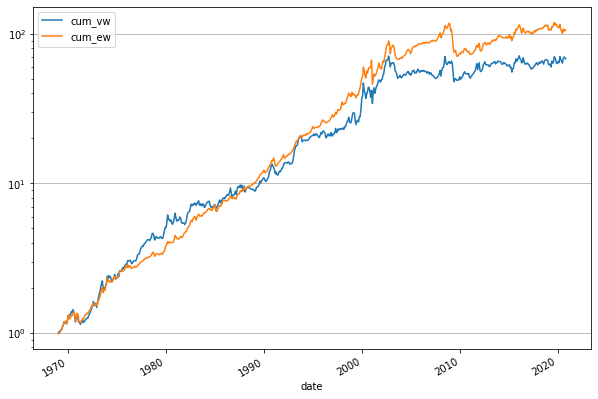

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
portfolios2 = portfolios2.sort_values('date') 
portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1
portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1
(
    portfolios2
    .assign(date=pd.to_datetime(portfolios2['date']))
    .assign(cum_vw=portfolios2['cum_vw']+1)
    .assign(cum_ew=portfolios2['cum_ew']+1)
    .plot(x='date', y=['cum_vw','cum_ew'] , logy=True).grid(axis='y')
)

Five Factor Model


In [ ]:
five_factor_monthly = five_factor_monthly.assign(end_of_month = lambda df: df['dt'].apply(end_of_month)) 